# Продвинутое машинное обучение
# Домашнее задание 2

Второе домашнее задание — самое большое в курсе, в нём придётся и концептуально подумать о происходящем, и технические трудности тоже порешать. Как и раньше, в качестве решения **ожидается ссылка на jupyter-ноутбук на вашем Github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Как всегда, любые комментарии, новые идеи и рассуждения на тему категорически приветствуются.

Второе задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить **вероятностную рейтинг-систему для спортивного "Что? Где? Когда?" (ЧГК)**.

**Background**: в спортивном "Что? Где? Когда?" соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, то есть в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
* построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
* при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и так далее; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
* а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента в базу результатов начали вносить все повопросные результаты команд, то есть в данных будут записи вида "какая команда на какой вопрос правильно ответила".

Я сделал за вас только первый шаг: выкачал через API [сайта рейтинга ЧГК](https://rating.chgk.info/) все нужные данные, чтобы сайт не прилёг под вашими многочисленными скрейперами. :) Полученные данные лежат в формате *pickle* вот здесь:

https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip

## Задание 1

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле *mask* в results.pkl). Для унификации предлагаю:
 * взять в тренировочный набор турниры с dateStart из 2019 года;
 * в тестовый — турниры с dateStart из 2020 года.

### Решение

#### Импорт библиотек

In [2]:
from collections import defaultdict
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import optim
from torch import nn
from scipy.stats import kendalltau, spearmanr
from sklearn.preprocessing import OneHotEncoder
from IPython.display import clear_output
from IPython.display import Image

In [2]:
TOP_N = 20  # number of top players and tournaments to consider
N_EPOCHS = 10  # number of epochs to train the model

#### Загрузка данных

In [3]:
if not os.path.exists("/content/chgk.zip"):
    !rm -rf chgk.zip
    !wget -q https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip
    !unzip -oq chgk.zip

##### Игроки

In [4]:
players = pd.read_pickle("/content/players.pkl")
players = pd.DataFrame.from_dict(players, orient="index")

In [5]:
players.head()

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


##### Турниры

In [6]:
tournaments = pd.read_pickle("/content/tournaments.pkl")
tournaments = pd.DataFrame.from_dict(tournaments, orient="index")

In [7]:
tournaments.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [8]:
min_start_date = tournaments["dateStart"].min().split('T')[0]
max_start_date = tournaments["dateStart"].max().split('T')[0]

print(f"Minimum tournament start date: {min_start_date}.")
print(f"Maximum tournament start date: {max_start_date}.")

Minimum tournament start date: 1992-09-08.
Maximum tournament start date: 2021-03-05.


In [9]:
min_end_date = tournaments["dateEnd"].min().split('T')[0]
max_end_date = tournaments["dateEnd"].max().split('T')[0]

print(f"Minimum tournament end date: {min_end_date}.")
print(f"Maximum tournament end date: {max_end_date}.")

Minimum tournament end date: 1992-09-10.
Maximum tournament end date: 2021-03-07.


##### Результаты

In [10]:
results = pd.read_pickle("/content/results.pkl")

#### Формирование датасета

In [11]:
def build_dataset(year):
    data = defaultdict(list)

    for num, teams in results.items():
        tournament_year = int(tournaments.at[num, "dateStart"].split('-')[0])
        for team in teams:
            for member in team["teamMembers"]:
                if tournament_year == year and team.get("mask", None):
                    data[num].append({
                        "tournament_id": num,
                        "tournament_name": tournaments.at[num, "name"],
                        "team_id": team["team"]["id"],
                        "team_name": team["team"]["name"],
                        "questions_mask": team.get("mask", None),
                        "questionQty": tournaments.at[num, "questionQty"],
                        "position": team.get("position", None),
                        "player_id": member["player"]["id"],
                        "player_name": member["player"]["surname"] + " " + \
                                       member["player"]["name"]
                    })
    return data

Разделим данные на тренировочный и тестовый наборы:

In [12]:
train_data = build_dataset(2019)
test_data = build_dataset(2020)

В данных присутствуют команды, длина маски ответов которых не сооответствует количеству вопросов в турнире. Отфильтруем такие команды:

In [13]:
data_cleaned = defaultdict(list)
errors = []

for tournament_id, teams in train_data.items():
    for team in teams:
        if len(team["questions_mask"]) == sum(team["questionQty"].values()):
            data_cleaned[tournament_id].append(team)
        else:
            errors.append(str(tournament_id))

train_data = data_cleaned

print(f"Number of teams with mismatched question masks: " \
      f"{len(errors)}.")
print(f"Number of tournaments with mismatched team question masks: " \
      f"{len(set(errors))}.")
print("IDs of tournaments with mismatched team question masks:")
print(', '.join(sorted(set(errors))))

Number of teams with mismatched question masks: 37040.
Number of tournaments with mismatched team question masks: 12.
IDs of tournaments with mismatched team question masks:
5462, 5553, 5554, 5703, 5760, 5864, 6026, 6085, 6090, 6249, 6254, 6255


In [14]:
print(f"Unique tournaments in train data: {len(train_data)}.")
print(f"Unique tournaments in test data: {len(test_data)}.")

Unique tournaments in train data: 675.
Unique tournaments in test data: 173.


In [15]:
train_data = [x for _, v in train_data.items() for x in v]
test_data = [x for _, v in test_data.items() for x in v]

In [16]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

Итоговое количество данных в тренировочном и тестовом наборах данных:

In [17]:
train_df.shape[0], test_df.shape[0]

(414743, 112841)

Итоговое количество турниров в тренировочном и тестовом наборах данных:

In [18]:
train_df["tournament_id"].nunique(), test_df["tournament_id"].nunique()

(675, 173)

In [19]:
train_df.head()

,tournament_id,tournament_name,team_id,team_name,questions_mask,questionQty,position,player_id,player_name
0,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,6212,Выменец Юрий
1,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,18332,Либер Александр
2,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,18036,Левандовский Михаил
3,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,22799,Николенко Сергей
4,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,"{'1': 12, '2': 12, '3': 12}",1.0,15456,Коновалов Сергей


In [20]:
# We won't need results anymore, so let's clear RAM:
del results
del train_data
del test_data

## Задание 2

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
 * повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
 * в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
 * для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Преобразуем тренировочные данные в повопросные результаты по игрокам. В качестве ID вопроса будем использовать формат `<ID турнира>_<порядковый номер вопроса>`. Кроме того, не будем учитывать вопросы с неизвестным статусом, помеченные как `X` и `?` в маске.

In [21]:
qa_data = {
    "question_id": [],
    "player_id": [],
    "team_id": [],
    "tournament_id": [],
    "answer_label": [],
}

for tournament_id, team_id, player_id, mask in zip(train_df["tournament_id"],
                                                   train_df["team_id"],
                                                   train_df["player_id"],
                                                   train_df["questions_mask"]):
    for index, value in enumerate(mask):
        if value not in ["X", "?"]:
            qa_data["tournament_id"].append(tournament_id)
            qa_data["team_id"].append(team_id)
            qa_data["question_id"].append(f"{tournament_id}_{index}")
            qa_data["player_id"].append(player_id)
            qa_data["answer_label"].append(int(value))

In [22]:
qa_data_df = pd.DataFrame(qa_data)

In [23]:
# Decrease RAM consuming and get some speedup
# by changing types from int64 to smaller ones:
qa_data_df = qa_data_df.astype(dtype={
    "player_id": np.uint32,
    "team_id": np.uint32,
    "tournament_id": np.uint32,
    "answer_label": np.uint8
})

qa_data = qa_data_df.copy()

In [24]:
qa_data_df.head()

,question_id,player_id,team_id,tournament_id,answer_label
0,4772_0,6212,45556,4772,1
1,4772_1,6212,45556,4772,1
2,4772_2,6212,45556,4772,1
3,4772_3,6212,45556,4772,1
4,4772_4,6212,45556,4772,1


In [25]:
qa_data_df.shape

(17739658, 5)

Произведём One Hot преобразование идентификаторов игроков и вопросов, чтобы параметры модели представляли собой вектор $w = (S_1, S_2, ..., S_N, q_1, q_2, ..., q_M, \mu),$ где $N$ — общее количество игроков, $M$ — общее количество вопросов. Таким образом, модель будет учитывать "силы" игроков $S_i, i = 1, ..., N$ и сложность вопросов $q_j, j = 1, ..., M$. Здесь $\mu$ — глобальная константа.

In [26]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(
    qa_data_df[["player_id", "question_id"]]
)

Определим модель и $M$-шаг. На $M$-шаге происходит простое обучение модели при заданных "силах" игроков и сложностях вопросов с уточнением параметров модели.

In [27]:
class LogisticRegression(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

In [28]:
def m_step(model, x, y_true, lr=3e-4, n_iter=100):
    model.fc.reset_parameters()
    loss_func = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr)

    for i in range(n_iter):
        opt.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y_true)
        loss.backward()
        opt.step()

Обучим модель предсказывать событие $z_{ij}$, соответствующее тому, что игрок $i$ ответил на вопрос $j$.

При этом будем пользоваться следующим предположением: если команда $t$ ответила на вопрос $j$ (событие $x_{tj}$), то и каждый её член ответил на этот вопрос, и наоборот, если команда не ответила на вопрос — значит, ни один её член не ответил на вопрос.

Тогда:
$$p(z_{ij}=1) = p(x_{tj}=1) = \sigma(\mu + S_i + q_j)$$

Поскольку метки для $p(x_{tj}=1)$ имеются в нашем тренировочном наборе данных, можно приступать к моделированию.

In [29]:
train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(qa_data_df["answer_label"].values).view(-1, 1)

model = LogisticRegression(x.shape[1])

In [30]:
m_step(model, x, y, lr=1, n_iter=100)

Введём функцию для вывода топ-$n$ игроков на основании их силы, полученной из модели:

In [31]:
def get_top_players(parameters, top_n=20):
    player_weights = {}

    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]

    top_players = sorted([(k, v) for k, v in player_weights.items()],
                         reverse=True, key=lambda x: x[1])[:top_n]

    df_top_players = {
        "player_id": [],
        "surname": [],
        "name": [],
        "skill": [],
        "place": [],
    }

    for place, (id, skill) in enumerate(top_players):
        df_top_players["player_id"].append(id)
        df_top_players["surname"].append(players.at[id, "surname"])
        df_top_players["name"].append(players.at[id, "name"])
        df_top_players["skill"].append(skill)
        df_top_players["place"].append(place + 1)

    df_top_players = pd.DataFrame(df_top_players)

    return df_top_players

Сравним позиции игроков на основе полученного рейтинга с реальными позициями на дату 26 декабря 2019 года:

In [32]:
df_top_players = get_top_players(model.fc.weight.data[0].numpy(), TOP_N)
df_top_players

,player_id,surname,name,skill,place
0,27403,Руссо,Максим,3.369566,1
1,4270,Брутер,Александра,3.231219,2
2,28751,Семушин,Иван,3.183629,3
3,27822,Савченков,Михаил,3.106301,4
4,30270,Спешков,Сергей,3.028781,5
5,30152,Сорожкин,Артём,3.020688,6
6,40411,Кудинов,Дмитрий,3.017081,7
7,38175,Пилипенко,Максим,2.951325,8
8,20691,Мереминский,Станислав,2.920612,9
9,202410,Подюкова,Валентина,2.875072,10


TOP-20-2019


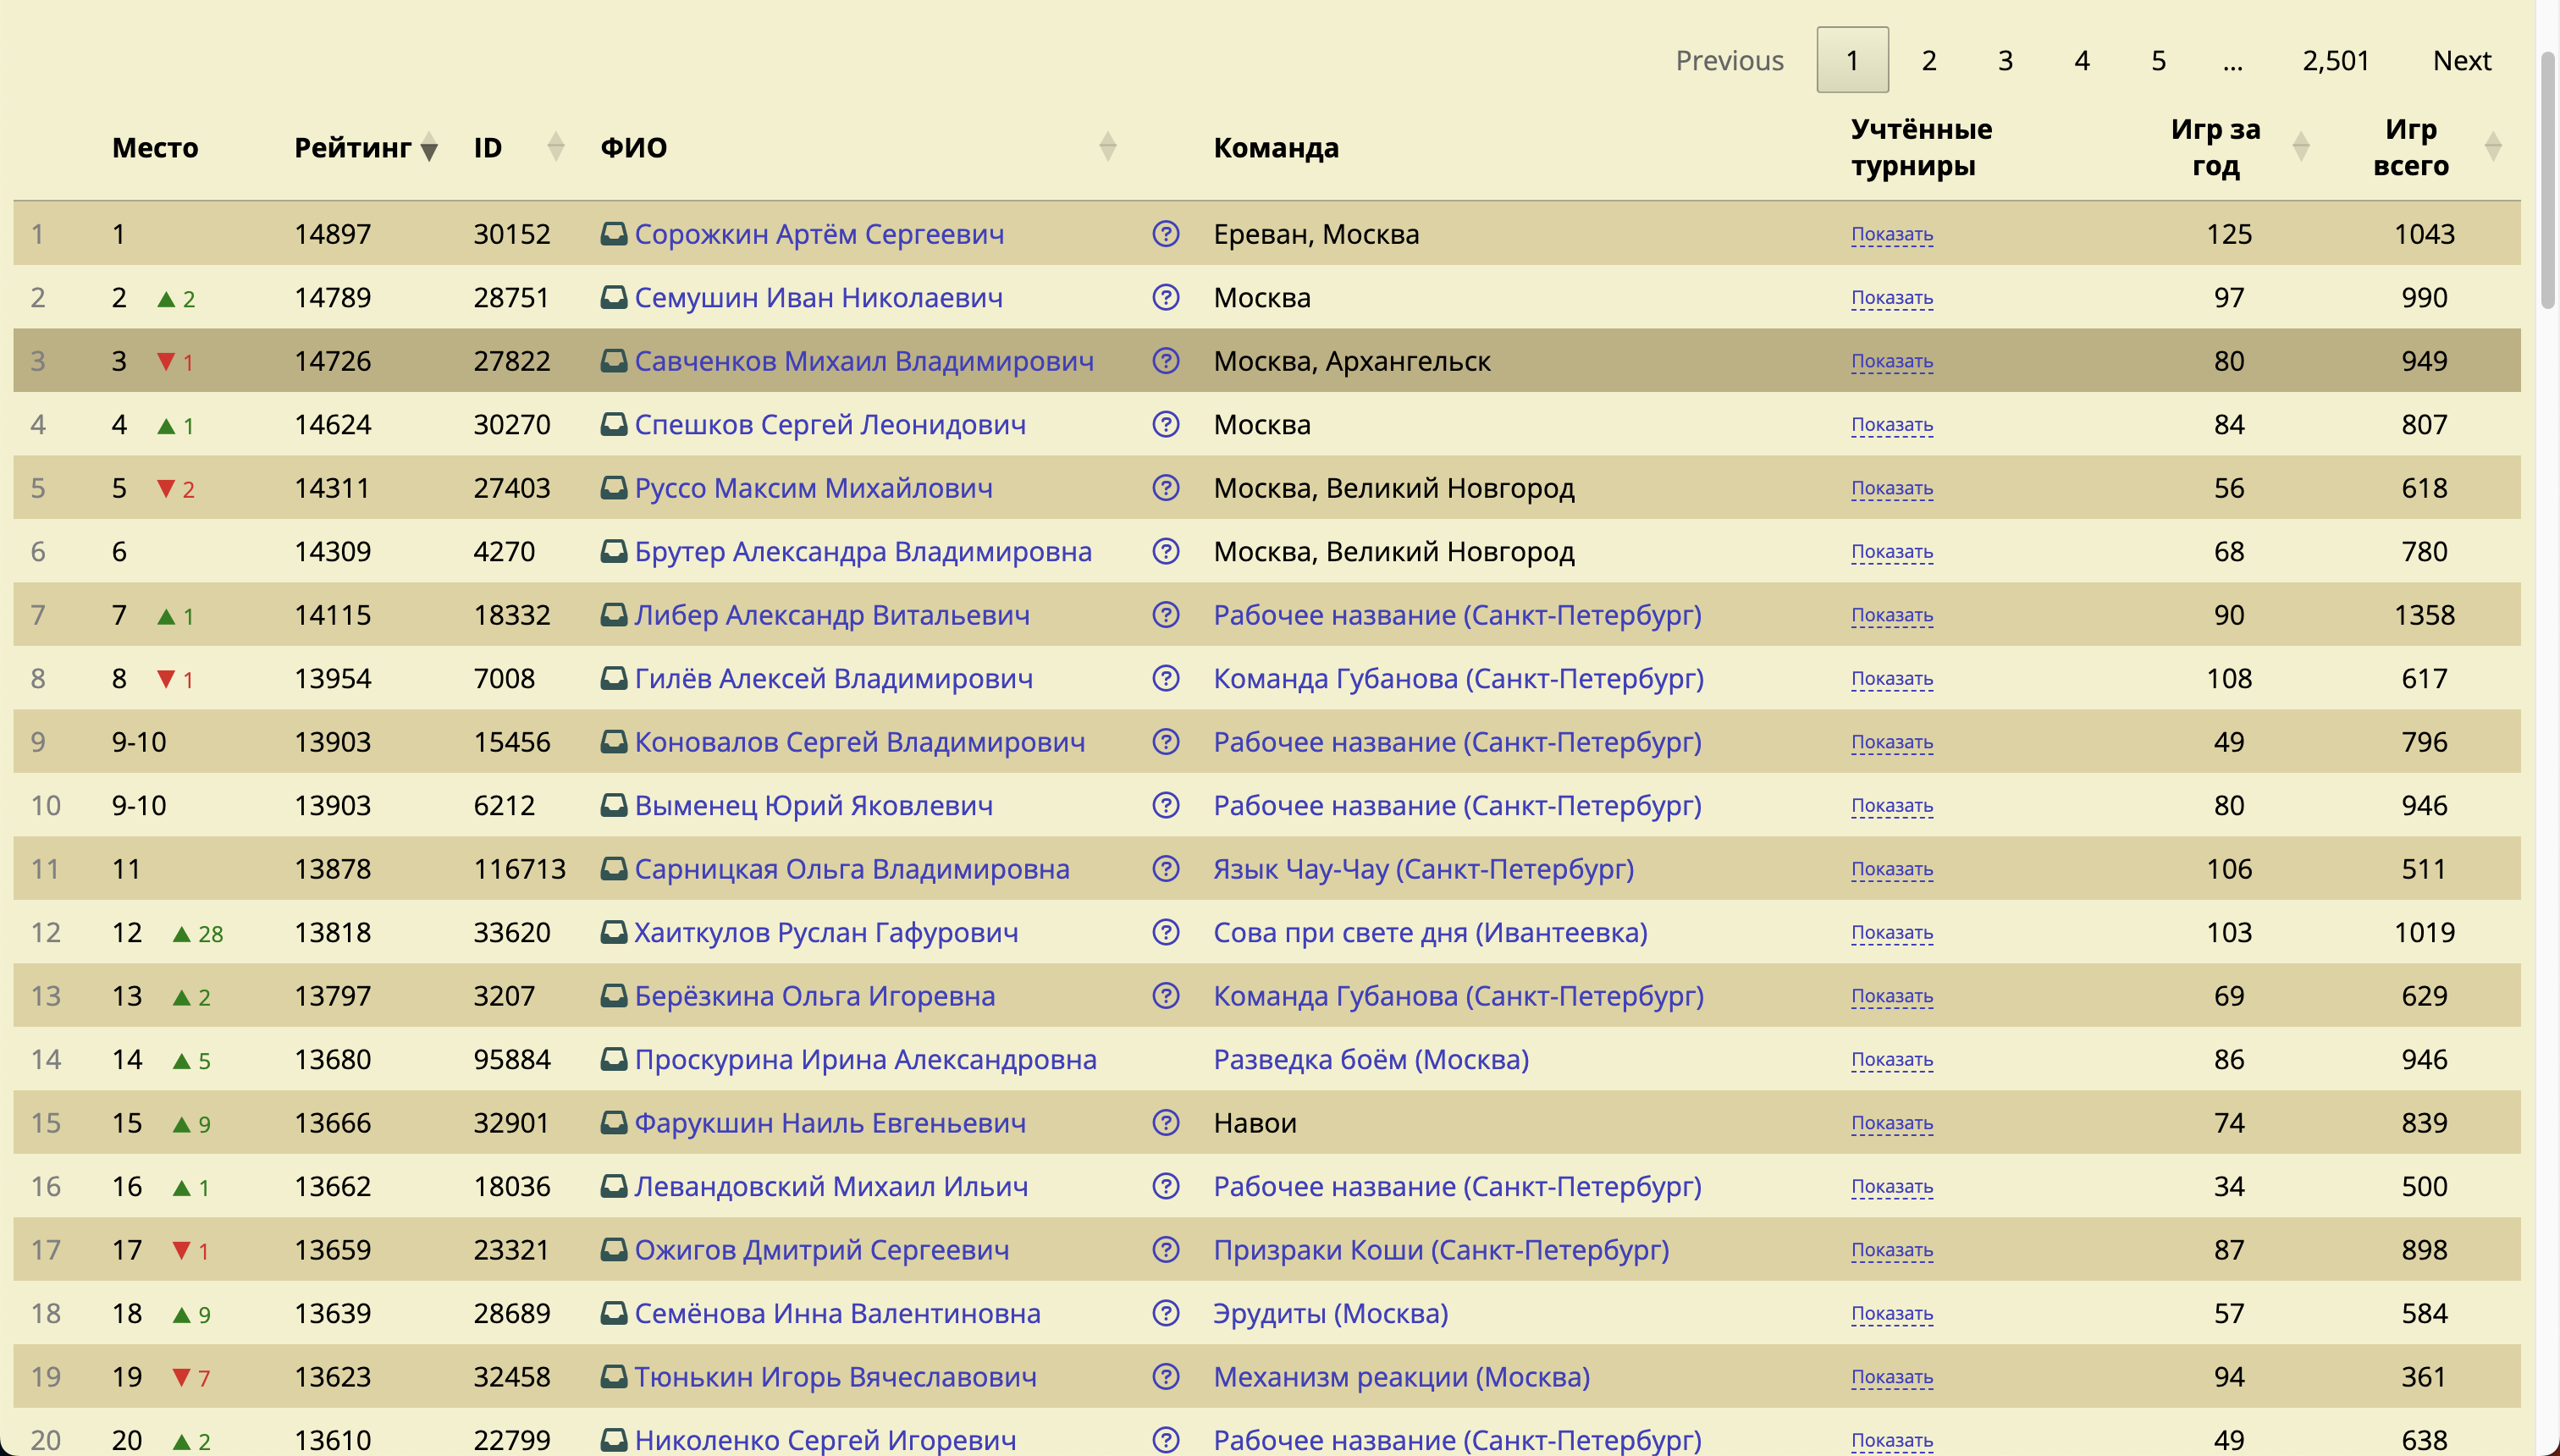

In [1]:
print('TOP-20-2019')
Image("top-20-2019.png", width=1080, height=720)

Как можно заметить, ранжирование некоторых игроков очень близко к реальному рейтингу, хотя доля игроков, отсутствуюших в реальном рейтинге, также велика.

## Задание 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
 * предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
 * в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете *scipy*) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров (для самопроверки: у меня средняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг).

Силу команды будем трактовать как вероятность того, что хотя бы один её член ответит на вопрос средней сложности.

$$\displaystyle t_i = 1 - \prod_{j=1}^{N}{(1 - \sigma(\mu + S_{ij} + q_{mean}))}$$

где:<br>
* $S_{ij}$ — сила игрока $j$ в команде $i$,
* $N$ — количество игроков в команде $i$,
* $q_{mean}$ — вопрос средней сложности,
* $\mu$ — глобальная константа.

Функция для вычисления ранговых корреляций Спирмена и Кендалла:

In [35]:
def calc_metrics(data, encoder, parameters, intercept):
    player_weights = {}
    count = 0
    question_sum = 0
    player_sum = 0
    player_cnt = 0
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
            player_sum += parameters[i]
            player_cnt += 1
        else:
            question_sum += parameters[i]
            count += 1
    question_mean = question_sum / count
    data["player_weights"] = data["player_id"].map(player_weights)
    data["player_weights"].fillna(player_sum / player_cnt, inplace=True)
    data["players_proba"] = data["player_weights"].apply(
        lambda x: 1 / (1 + np.exp(-(x + question_mean + intercept)))
    )
    probas = data.groupby(["tournament_id", "team_id"])["players_proba"].apply(
        lambda x: np.prod(1 - x)
    )
    position = data.groupby(["tournament_id", "team_id"])["position"].first()
    group_data = pd.concat([probas, position], axis=1)
    group_data.sort_values(["tournament_id", "players_proba"],
                           ascending=[True, True], inplace=True)
    spearman = group_data.groupby("tournament_id").apply(
        lambda x: spearmanr(x["position"], x["players_proba"]).correlation
    ).mean()
    kendall = group_data.groupby("tournament_id").apply(
        lambda x: kendalltau(x["position"], x["players_proba"]).correlation
    ).mean()
    return spearman, kendall

In [36]:
spearman, kendall = calc_metrics(test_df, encoder,
                                 model.fc.weight.data[0].numpy(),
                                 model.fc.bias.data[0].numpy())
print(f"Spearman: {spearman:.6f}")
print(f"Kendall:  {kendall:.6f}")

Spearman: 0.785901
Kendall:  0.629029


## Задание 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
 * предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные "игрок X ответил на вопрос Y" при условии данных должны стать зависимыми для игроков одной и той же команды;
 * разработайте EM-схему для обучения этой модели, реализуйте её в коде;
 * обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

Предположим следующее:
1. если хотя бы один из игроков команды ответил на вопрос, то и вся команда ответила на вопрос;
2. если команда не ответила на вопрос, то и все её члены не ответили на вопрос;
3. игроки отвечают на вопрос независимо.

Теперь будем моделировать вероятность того, что игрок $i$ ответил на вопрос $j$, при условии, что команда игрока $i$ ответила на этот вопрос:
$$p(z_{ij}=1|t_i=1)$$

Согласно второму предположению, если команда не ответила на вопрос, то и ни один её игрок не ответил (либо команда отвергла правильный ответ, что в некотором смысле почти то же самое):
$$p(z_{ij}=1|t_i=0) = 0$$

В таком случае воспользуемся теоремой Байеса:
$$\displaystyle p(z_{ij}=1|t_i=1) = \frac{p(t_i=1|z_{ij}=1)p(z_{ij}=1)}{p(t_i=1)}$$

Мы знаем, что:
* $p(t_i=1|z_{ij}=1) = 1$ согласно второму предположению выше;
* $p(z_{ij}=1) = \sigma(\mu + S_i + q_j)$ — предсказание модели на $M$-шаге;
* $\displaystyle p(t_i=1) = 1 - \prod_{k=1}^{N}{(1 - \sigma(\mu + S_{ik} + q_{j}))}$ — вероятность команды ответить на вопрос равна разности единицы и произведения вероятностей того, что каждый игрок команды не ответит на вопрос.

Тогда:
$$\displaystyle p(z_{ij}=1|t_i=1) = \frac{\sigma(\mu + S_i + q_j)}{1 - \prod_{k=1}^{N}{(1 - \sigma(\mu + S_{ik} + q_{j}))}}$$

Это и будет являться $E$-шагом. Реализуем его в коде:

In [37]:
def e_step(data, predicts):
    data["label"] = predicts
    data.loc[data["answer_label"] == 0, "label"] = 0
    idx = data["answer_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question_id"])["label"].transform(
        lambda x: 1 - np.prod(1 - x.values)
    )
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp  
    return data

Epoch: 10
    Spearman: 0.801505
    Kendall:  0.646276


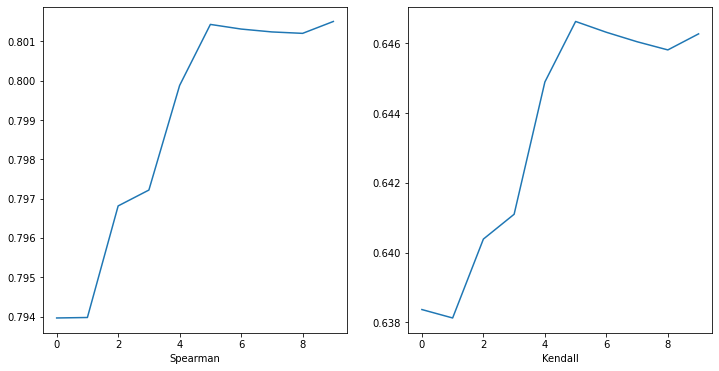

In [38]:
predicts = model(x).detach().numpy().ravel()

spearman_metric = []
kendall_metric = []

for i in range(N_EPOCHS):
    qa_data_df = e_step(qa_data_df, predicts)
    y = torch.FloatTensor(qa_data_df["label"].values).view(-1, 1)
    m_step(model, x, y, lr=1, n_iter=100)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    spearman, kendall = calc_metrics(test_df, encoder,
                                     model.fc.weight.data[0].numpy(),
                                     model.fc.bias.data[0].numpy())
    spearman_metric.append(spearman)
    kendall_metric.append(kendall)
    clear_output(True)
    print(f"Epoch: {i + 1}")
    print(f"    Spearman: {spearman:.6f}")
    print(f"    Kendall:  {kendall:.6f}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(spearman_metric)
    ax[0].set_xlabel("Spearman")
    ax[1].plot(kendall_metric)
    ax[1].set_xlabel("Kendall")
    plt.show()

## Задание 5

А что там с вопросами? Постройте "рейтинг-лист" турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? *Если будет интересн*о: постройте топ сложных и простых вопросов со ссылками на конкретные записи в [базе вопросов ЧГК](http://db.chgk.info) (это чисто техническое дело, тут никакого ML нету).

Для простоты будем считать, что сложность турнира — это средняя сложность вопросов в нём.

In [39]:
parameters = model.fc.weight.data[0].numpy()

question_weights = {}
for i, c in enumerate(encoder.get_feature_names()):
    if c.startswith("x1_"):
        question_weights[c[3:]] = parameters[i]

In [40]:
tournament_weights = qa_data_df.groupby("tournament_id")["question_id"] \
    .apply(lambda x: np.mean([question_weights[q] for q in x])) \
    .sort_values()

In [41]:
tournament_weights = tournament_weights.reset_index().rename(columns={
    "question": "difficulty"
})

In [42]:
print(f"Top {TOP_N} most difficult tournaments:")
tournament_weights.head(TOP_N).merge(
    tournaments[["id", "name"]].set_index("id"),
    left_on="tournament_id", right_on="id",
)

Top 20 most difficult tournaments:


,tournament_id,question_id,name
0,6149,-7.500016,Чемпионат Санкт-Петербурга. Первая лига
1,5717,-3.631883,Чемпионат Таджикистана
2,5928,-3.161070,Угрюмый Ёрш
3,5930,-3.116610,Зеркало мемориала памяти Михаила Басса
4,5684,-3.092730,Синхрон высшей лиги Москвы
5,6101,-3.085368,Воображаемый музей
6,5159,-2.926012,Первенство правого полушария
7,5943,-2.923144,Чемпионат Мира. Этап 2 Группа С
8,5942,-2.773703,Чемпионат Мира. Этап 2. Группа В
9,5532,-2.756274,Седьмая октава: Кубок Равноденствия. Лига Наци...


In [43]:
print(f"Top {TOP_N} least difficult tournaments:")
tournament_weights.tail(TOP_N).merge(
    tournaments[["id", "name"]].set_index("id"),
    left_on="tournament_id", right_on="id",
)

Top 20 least difficult tournaments:


,tournament_id,question_id,name
0,5697,1.394509,Школьный Синхрон-lite. Выпуск 3.1
1,5601,1.398673,Межфакультетский кубок МГУ. Отбор №4
2,5702,1.400606,(а)Синхрон-lite. Лига старта. Эпизод IX
3,5535,1.412385,Кубок Тышкевичей
4,6254,1.448863,Школьная лига
5,5954,1.519255,Школьная лига. II тур.
6,5012,1.573815,Школьный Синхрон-lite. Выпуск 2.5
7,5388,1.609882,Олимпиада Приволжского федерального округа. Финал
8,5013,1.614798,(а)Синхрон-lite. Лига старта. Эпизод V
9,6003,1.626808,Второй тематический турнир имени Джоуи Триббиани


Как нетрудно заметить, самые сложные турниры состоят в основном из чемпионатов и игр высшей лиги, в то время как среди самых простых доминируют школьные и университетские игры, что соответствует базовой интуиции.

## Задание 6

*Бонус*: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в [официальном рейтинге ЧГК](http://rating.chgk.info), вы увидите, что это какие-то непонятные ноунеймы (для самопроверки: а вот те игроки, кто сыграл от тысячи вопросов и больше и при этом всё равно попал в топ-100 весов модели, должны быть настоящими топовыми игроками из ведущих команд официального рейтинга. Если это не так, опять же, скорее всего где-то баг). В baseline-модели, скорее всего, такой эффект будет гораздо слабее.

 Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:
 * сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
 * можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;
 * но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой "золотой середины" тут не получится;
 * предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).

### Решение

Посмотрим на количество вопросов, на которые ответил каждый игрок из топ-20, и количество турниров, в которых игрок поучаствовал:

In [44]:
questions_per_player = qa_data_df \
    .groupby("player_id")["question_id"] \
    .nunique()

tournaments_per_player = qa_data_df \
    .groupby("player_id")["tournament_id"] \
    .nunique()

In [45]:
df_top_players = get_top_players(model.fc.weight.data[0].numpy(), TOP_N)

df_top_players["num_tournaments"] = df_top_players["player_id"].apply(
    lambda x: tournaments_per_player[x]
)

df_top_players["num_questions"] = df_top_players["player_id"].apply(
    lambda x: questions_per_player[x]
)

df_top_players

,player_id,surname,name,skill,place,num_tournaments,num_questions
0,38175,Пилипенко,Максим,3.250396,1,1,36
1,22474,Немец,Илья,3.117976,2,2,75
2,14996,Козлова,Ольга,2.660004,3,1,36
3,199963,Бровченко,Елена,2.645308,4,1,36
4,202410,Подюкова,Валентина,2.572643,5,1,36
5,40411,Кудинов,Дмитрий,2.472786,6,1,45
6,188876,Голудина,Мария,2.445972,7,1,36
7,33459,Фрайман,Феликс,2.434326,8,1,36
8,17750,Лазарева,Галина,2.357356,9,1,36
9,199114,Луконин,Дмитрий,2.302468,10,1,30


In [46]:
qa_data_df = qa_data.copy()

In [47]:
qa_data_df["num_tournaments"] = qa_data_df["player_id"].apply(
    lambda x: tournaments_per_player[x]
)

qa_data_df["num_questions"] = qa_data_df["player_id"].apply(
    lambda x: questions_per_player[x]
)

In [48]:
questions_threshold = qa_data_df["num_questions"].quantile(0.2)
questions_threshold

285.0

Такой порог будет соответствовать необходимости отыграть примерно 6-10 турниров. Это довольно много, но давайте посмотрим, что произойдёт с поведением модели.

In [49]:
qa_data_df = qa_data_df[qa_data_df["num_questions"] > questions_threshold]

In [50]:
qa_data_df.shape

(14185333, 7)

In [51]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(
    qa_data_df[["player_id", "question_id"]]
)

In [52]:
train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(qa_data_df["answer_label"].values).view(-1, 1)

model = LogisticRegression(x.shape[1])

Epoch: 10
    Spearman: 0.676025
    Kendall:  0.533902


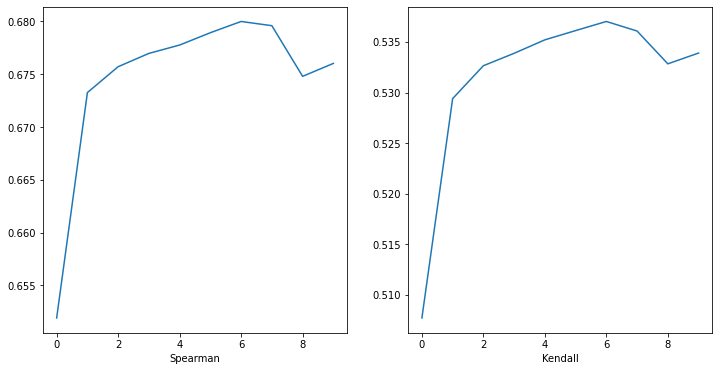

In [53]:
predicts = model(x).detach().numpy().ravel()

spearman_metric = []
kendall_metric = []

for i in range(N_EPOCHS):
    qa_data_df = e_step(qa_data_df, predicts)
    y = torch.FloatTensor(qa_data_df["label"].values).view(-1, 1)
    m_step(model, x, y, lr=1, n_iter=100)
    torch.save(model.state_dict(), f"model_filtered_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    spearman, kendall = calc_metrics(test_df, encoder,
                                     model.fc.weight.data[0].numpy(),
                                     model.fc.bias.data[0].numpy())
    spearman_metric.append(spearman)
    kendall_metric.append(kendall)
    clear_output(True)
    print(f"Epoch: {i + 1}")
    print(f"    Spearman: {spearman:.6f}")
    print(f"    Kendall:  {kendall:.6f}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(spearman_metric)
    ax[0].set_xlabel("Spearman")
    ax[1].plot(kendall_metric)
    ax[1].set_xlabel("Kendall")
    plt.show()

Как и ожидалось, метрики модели значительно ухудшились.